In [1]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from arch.bootstrap import StationaryBootstrap
from arch.bootstrap import IIDBootstrap

Importing plotly failed. Interactive plots will not work.


## Load data

In [2]:
df = pd.read_csv('./../../../data/error_dfs/error_2019_may2021_VAR.csv', converters={'ags2': str, 'ags5': str} )

In [3]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [4]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../../data/corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['error'] = df['ground_truth'] - df['pred']
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
0,2018-12-01,7.3,7.566702,01001,01,Schleswig-Holstein,"Flensburg, Stadt",-0.266702
1,2019-01-01,8.2,8.038843,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.161157
2,2019-02-01,7.8,8.022765,01001,01,Schleswig-Holstein,"Flensburg, Stadt",-0.222765
3,2019-03-01,7.8,7.754631,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.045369
4,2019-04-01,7.6,7.502805,01001,01,Schleswig-Holstein,"Flensburg, Stadt",0.097195
...,...,...,...,...,...,...,...,...
12025,2021-01-01,7.3,7.479328,16077,16,Thüringen,Altenburger Land,-0.179328
12026,2021-02-01,7.3,7.435923,16077,16,Thüringen,Altenburger Land,-0.135923
12027,2021-03-01,7.2,7.046545,16077,16,Thüringen,Altenburger Land,0.153455
12028,2021-04-01,6.9,6.780956,16077,16,Thüringen,Altenburger Land,0.119044


In [5]:
df['y'] = np.where(df['date'] >= '2021-03-01', df['pred'], df['ground_truth'])

In [6]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [7]:
%%time

ci = pd.DataFrame(columns = ['lower', 'higher','ags5','date'])
ci['date'] = pd.to_datetime(ci['date'], format = '%Y-%m-%d')

ags5 = list(set(df['ags5']))
def func(x):
    return x
    
for i in ags5:
    df_ags5 = df[df["ags5"] == i]
    pred_ags5 = df_ags5['y']
    bs = StationaryBootstrap(10, pred_ags5)
    ci_ags5 = bs.conf_int(func)
    ci_ags5 = pd.DataFrame(ci_ags5).T
    ci_ags5.columns = ['lower', 'higher']
    ci_ags5['ags5'] = i
    ci_ags5['date'] = list(df_ags5['date'])
    ci = ci.append(ci_ags5)
ci

CPU times: user 1min 59s, sys: 3.05 s, total: 2min 2s
Wall time: 3min 40s


,lower,higher,ags5,date
0,4.000000,6.100000,05314,2018-12-01
1,4.600000,6.700000,05314,2019-01-01
2,4.600000,6.700000,05314,2019-02-01
3,4.400000,6.500000,05314,2019-03-01
4,4.000000,6.100000,05314,2019-04-01
...,...,...,...,...
25,5.659524,7.300000,01056,2021-01-01
26,5.859524,7.500000,01056,2021-02-01
27,5.720778,7.361253,01056,2021-03-01
28,5.940476,7.580951,01056,2021-04-01


In [8]:
df = pd.merge(df, ci, on = ['ags5','date'])


In [9]:
df = df[df['ags5']=='11000']
df

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error,y,lower,higher
9720,2018-12-01,7.6,7.631790,11000,11,Berlin,Berlin,-0.031790,7.600000,4.360254,7.600000
9721,2019-01-01,8.1,8.120488,11000,11,Berlin,Berlin,-0.020488,8.100000,5.375161,8.600000
9722,2019-02-01,7.9,7.985466,11000,11,Berlin,Berlin,-0.085466,7.900000,4.960254,8.200000
9723,2019-03-01,7.8,7.740870,11000,11,Berlin,Berlin,0.059130,7.800000,4.760254,8.000000
9724,2019-04-01,7.7,7.620399,11000,11,Berlin,Berlin,0.079601,7.700000,4.560254,7.800000
9725,2019-05-01,7.8,7.170848,11000,11,Berlin,Berlin,0.629152,7.800000,4.760254,8.000000
9726,2019-06-01,7.8,7.647546,11000,11,Berlin,Berlin,0.152454,7.800000,4.760254,8.000000
9727,2019-07-01,8.0,7.857378,11000,11,Berlin,Berlin,0.142622,8.000000,5.160254,8.400000
9728,2019-08-01,8.0,7.932568,11000,11,Berlin,Berlin,0.067432,8.000000,5.160254,8.400000
9729,2019-09-01,7.8,7.597896,11000,11,Berlin,Berlin,0.202104,7.800000,4.775161,8.000000


In [13]:
df = df[df['date'] > '2020-06-01'] 

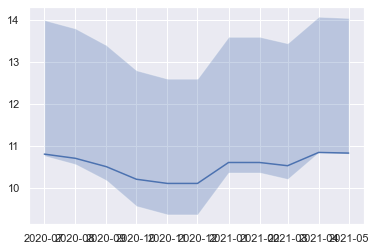

In [14]:
plt.plot(df['date'],df['y'])
plt.fill_between(df['date'], df['lower'], df['higher'], alpha=.3)
